<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [1]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [2]:
!nvidia-smi

Thu Aug  6 01:11:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%pip install cupy-cuda101

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [6]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [7]:
X = X.drop(['ID','WF','Set'],axis=1)

In [8]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Fill NaN's

In [9]:
X = X.fillna(method="ffill", axis=1) # ZOH
X = X.fillna(0)

In [10]:
y = y.fillna(method="ffill", axis=1) # ZOH
y = y.fillna(0)

## Scaling Data

In [11]:
directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))

directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
directions = directions.reset_index().drop('Time',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
X_columns = X.columns

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=X_columns)

In [14]:
X = pd.concat([X,directions],axis=1)

In [15]:
#y = scaler.fit_transform(y)
#y = pd.DataFrame(y)

In [16]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Speed 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,V_10mLast_Month_Variance,cos_day,...,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max,Sin_Wind Direction 100m,Cos_Wind Direction 100m,Sin_Wind Direction 10m,Cos_Wind Direction 10m
0,0.228968,0.130650,-0.080167,0.046187,-0.652228,0.730090,-0.235387,-0.710735,-0.998463,-0.998463,-0.998463,-0.982084,-0.982084,-0.982084,-0.104511,-0.104511,-0.104511,-0.051678,-0.051678,-0.051678,-0.097700,-0.097700,-0.097700,0.004222,0.004222,0.004222,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0.010180,0.999948,0.015634,0.999878
1,0.243537,0.136909,-0.099786,0.062691,-0.648044,0.979522,-0.209145,-0.704468,-0.997542,-0.997542,-0.997542,-0.979261,-0.979261,-0.979261,-0.094891,-0.094891,-0.094891,-0.042877,-0.042877,-0.042877,-0.082122,-0.082122,-0.082122,0.018267,0.018267,0.018267,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.994934,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.010097,0.999949,0.018097,0.999836
2,0.238667,-0.050938,-0.091757,0.056334,-0.590239,0.283872,-0.340364,-0.707170,-0.997906,-0.997906,-0.997906,-0.980376,-0.980376,-0.980376,-0.098689,-0.098689,-0.098689,-0.046352,-0.046352,-0.046352,-0.088273,-0.088273,-0.088273,0.012721,0.012721,0.012721,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.924962,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.002650,0.999996,0.017125,0.999853
3,0.189158,-0.002548,-0.083169,0.017554,-0.654321,0.149650,-0.399844,-0.751810,-0.999176,-0.999176,-0.999176,-0.984269,-0.984269,-0.984269,-0.111956,-0.111956,-0.111956,-0.058490,-0.058490,-0.058490,-0.109757,-0.109757,-0.109757,-0.006647,-0.006647,-0.006647,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

In [17]:
y

,ID,Production
12478,12479.0,1.49
12479,12480.0,2.48
12480,12481.0,2.21
12481,12482.0,1.49
12482,12483.0,1.25
...,...,...
18712,18713.0,1.56
18713,18714.0,1.29
18714,18715.0,0.89
18715,18716.0,1.08


## Subsets Creation

Convert Df's to Array on Correct Shape

In [18]:
n_steps = 7

In [19]:
# split a multivariate sequence into samples
def split_sequences(X, y, n_steps):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = X[i:end_ix, :-1], y[end_ix-1,-1]
		sample_X.append(seq_x)
		sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [20]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [21]:
n_features = sample_X.shape[2]

## Model

Model Creation Function:

In [22]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=1024,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.3)(hidden_1)
  hidden_1 = tf.keras.layers.BatchNormalization()(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=512, stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.3)(hidden_2)
  hidden_2 = tf.keras.layers.BatchNormalization()(hidden_2)


  # Output
  outputs = tf.keras.layers.PReLU()(hidden_2)
  outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)
  outputs = tf.keras.layers.BatchNormalization()(outputs)
  outputs = tf.keras.layers.Dense(units=1)(outputs)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [23]:
input_shape = (n_steps,n_features)

In [24]:
model = LSTM_Model(input_shape)

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 7, 94)]              0         
_________________________________________________________________
lstm (LSTM)                  (1, 7, 1024)              4583424   
_________________________________________________________________
dropout (Dropout)            (1, 7, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (1, 7, 1024)              4096      
_________________________________________________________________
lstm_1 (LSTM)                (1, 512)                  3147776   
_________________________________________________________________
dropout_1 (Dropout)          (1, 512)                  0         
_________________________________________________________________
batch_normalization_1 (Batch (1, 512)                 

## Validation

In [26]:
def metric_cnr(preds,labels):
    cape_cnr = 100*tf.math.reduce_sum(tf.math.abs(preds-labels))/tf.math.reduce_sum(labels)
    return cape_cnr

In [27]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
#batch_size = 1 * ((len(X) - len(X) // k_fold_splits) // (total_it))
batch_size = 1

In [28]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),metric_cnr])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['metric_cnr']).mean()
    val_score = np.array(history.history['val_metric_cnr']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    test_score = metric_cnr(preds,y_test)

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

Epoch 1/10
777/777 [==============================] - 7s 9ms/step - loss: 3.8686 - root_mean_squared_error: 1.9669 - metric_cnr: inf - val_loss: 12168.4854 - val_root_mean_squared_error: 110.3109 - val_metric_cnr: 32.9751
Epoch 2/10
777/777 [==============================] - 6s 8ms/step - loss: 3.8372 - root_mean_squared_error: 1.9589 - metric_cnr: 92.2569 - val_loss: 17785.6172 - val_root_mean_squared_error: 133.3627 - val_metric_cnr: 22.8119
Epoch 3/10
777/777 [==============================] - 6s 8ms/step - loss: 3.8249 - root_mean_squared_error: 1.9557 - metric_cnr: 91.0197 - val_loss: 15020.7842 - val_root_mean_squared_error: 122.5593 - val_metric_cnr: 13.1455
Epoch 4/10
777/777 [==============================] - 6s 8ms/step - loss: 3.8192 - root_mean_squared_error: 1.9543 - metric_cnr: 90.0198 - val_loss: 13364.5322 - val_root_mean_squared_error: 115.6051 - val_metric_cnr: 17.6631
Epoch 5/10
777/777 [==============================] - 6s 8ms/step - loss: 3.8174 - root_mean_squared

### Hold Out Score

In [30]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [32]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [33]:
model = LSTM_Model(input_shape)

In [34]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='hinge', metrics=[tf.keras.metrics.RootMeanSquaredError(),metric_cnr])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4672/4672 [==============================] - 39s 8ms/step - loss: 0.2626 - root_mean_squared_error: 2.3044 - metric_cnr: inf - val_loss: 5.2780 - val_root_mean_squared_error: 1171.9298 - val_metric_cnr: 99.5351
Epoch 2/10
4672/4672 [==============================] - 38s 8ms/step - loss: 0.2598 - root_mean_squared_error: 2.3459 - metric_cnr: 75.7159 - val_loss: 4.5143 - val_root_mean_squared_error: 874.7097 - val_metric_cnr: 99.3294
Epoch 3/10
4672/4672 [==============================] - 38s 8ms/step - loss: 0.2595 - root_mean_squared_error: 2.3259 - metric_cnr: 75.6104 - val_loss: 3.6291 - val_root_mean_squared_error: 789.3151 - val_metric_cnr: 99.3164
Epoch 4/10
4672/4672 [==============================] - 39s 8ms/step - loss: 0.2575 - root_mean_squared_error: 2.3097 - metric_cnr: 75.9539 - val_loss: 3.9015 - val_root_mean_squared_error: 858.5184 - val_metric_cnr: 99.3823


In [35]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

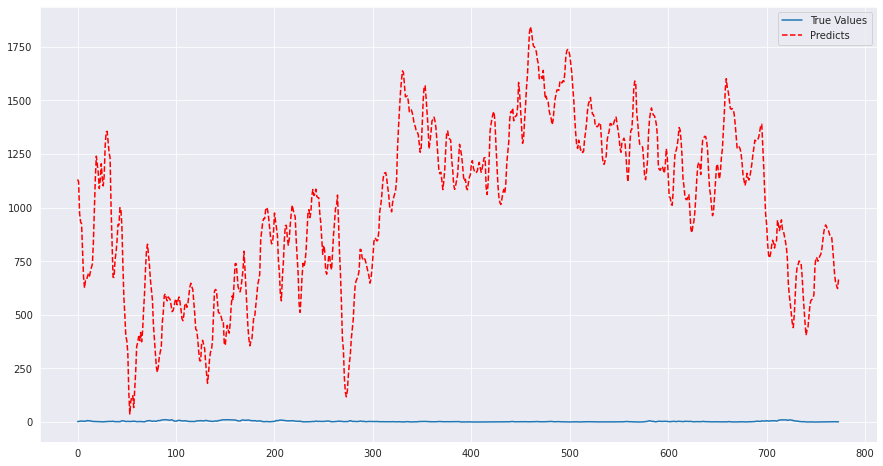

In [36]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()